In [1]:
import os
import cv2 
import numpy as np

from skimage.segmentation import chan_vese

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

import torch as T
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

import annoy

device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
print(f'Torch version is {T.__version__}. Using device {device}')

Torch version is 1.8.0.dev20201110+cu110. Using device cuda:0


In [2]:
def load_images(folder):
    images = []
    for file in os.listdir(folder):
        image = cv2.imread(f'{folder}/{file}', cv2.IMREAD_GRAYSCALE)
        images += [image[np.newaxis, :, :]]
    return np.concatenate(images, axis=0)

def resize_images(images):
    num = images.shape[0]
    new_images = np.zeros((num, 64, 128), dtype=np.uint8)
    new_images[:, 2:-3, 5:-5] = images
    return new_images
    
images = []
subset = []
for k, name in enumerate('ABC'):
    image_set = load_images(f'scibord/{name}')
    image_set = resize_images(image_set)
    images += [image_set]
    subset += [np.zeros(image_set.shape[0]) + k]
    
images = np.concatenate(images, axis=0)
subset = np.concatenate(subset, axis=0)

In [3]:
n = images.shape[0]
m = images.reshape(n, -1).mean(axis=1).reshape(n, 1, 1)
s = images.reshape(n, -1).std(axis=1).reshape(n, 1, 1)

fg_masks = images > m

fg_images = images.copy()
fg_images[fg_masks == False] = 0 

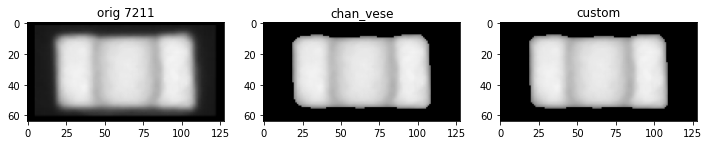

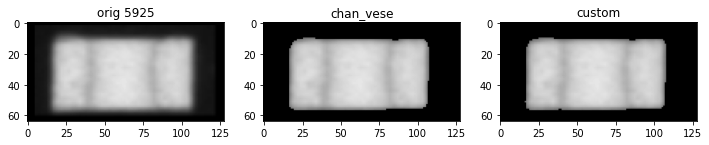

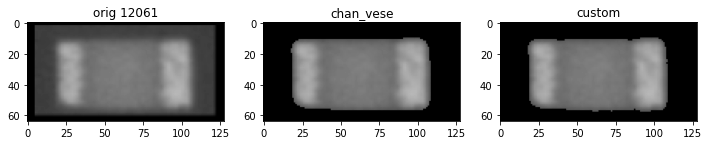

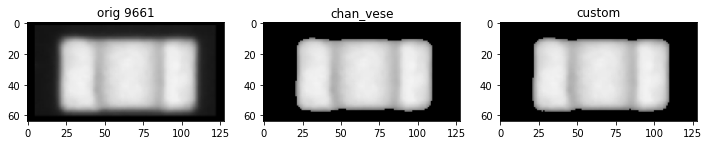

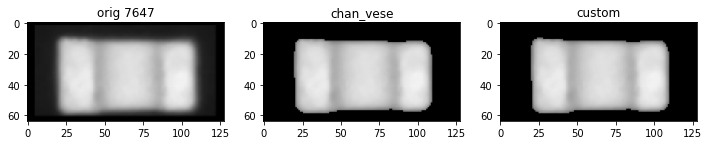

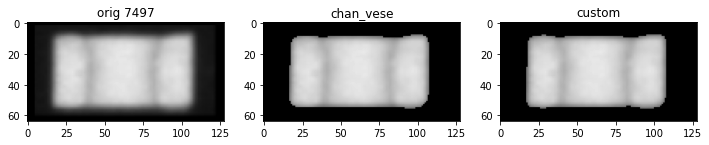

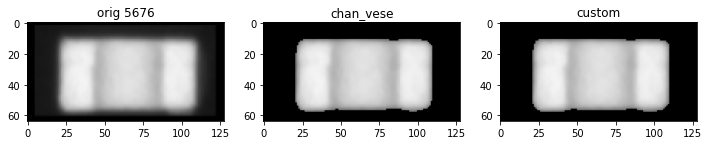

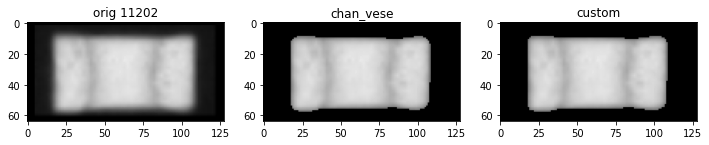

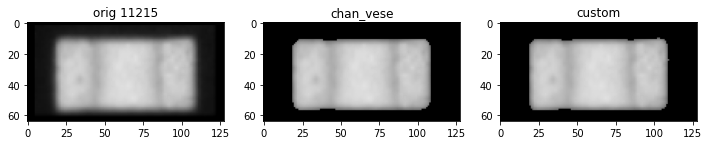

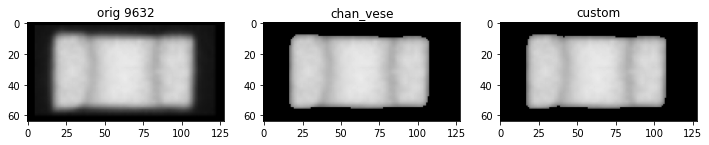

In [4]:
indeces = np.random.randint(0, images.shape[0] - 1, 10)

for k in indeces:
    plt.figure(figsize=(12, 6))
    plt.subplot(1,3,1)
    plt.title(f'orig {k}')
    plt.imshow(images[k, :, :], cmap='gray', vmin=0, vmax=255)
    plt.subplot(1,3,2)
    plt.title('chan_vese')
    plt.imshow(images[k, :, :] * chan_vese(images[k, :, :]), cmap='gray', vmin=0, vmax=255)
    plt.subplot(1,3,3)
    plt.title('custom')
    plt.imshow(fg_images[k, :, :], cmap='gray', vmin=0, vmax=255)
plt.show()
    

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, dims=(59, 118), device=device):
        super(Autoencoder, self).__init__()
        self.device = device
        self.mean_val = 0
        self.std_val = 1
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=4, stride=(2,4), padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 16, kernel_size=4, stride=4, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4 , stride=4, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(64, 16),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(            
#             nn.Linear(16, 64),
#             nn.ReLU(),
#             nn.Unflatten(1, (64, 1, 1)),            
            nn.ConvTranspose2d(64, 32, kernel_size=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=4),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=4, stride=4),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=(2,4), stride=(2, 4))
        )
        self.to(self.device)
        
        
    def train_model(self, images, batch_size=256, lr=5e-4, epochs=2000, print_rate=100):
        images = images[:, np.newaxis, :, :]
        images = images.astype(np.float32) / 255
        self.mean_val = images.mean()
        self.std_val = images.std()
        images = (images - self.mean_val) / self.std_val
        
        tensor = T.tensor(images, dtype=T.float32) / 255
        loader = DataLoader(TensorDataset(tensor), batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer =  Adam(params=self.parameters(), lr=lr)
        self.train()
        
        for epoch_no in range(epochs):
            current_loss = []
            for batch, in loader:
                batch = batch.to(device)
                values = self(batch) 
                loss = criterion(values, batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                current_loss += [loss.item()]
            if (epoch_no + 1) % print_rate == 0:
                print(f'Epoch {epoch_no + 1}: loss is {np.mean(current_loss)*1e4: .4f}')
        
    def save(self, path):
        print(f'Save model to {path}')
        T.save(self.state_dict(), path)
    
    def load(self, path):
        print(f'Load model from {path}')
        self.load_state_dict(T.load(path))        
        self.to(self.device)

    def eval_model(self, images, batch_size=512):
        self.eval()
        
        images = images[:, np.newaxis, :, :]
        images = images.astype(np.float32) / 255
        images = (images - self.mean_val) / self.std_val
        
        tensor = T.tensor(images, dtype=T.float32) / 255
        loader = DataLoader(TensorDataset(tensor), batch_size=batch_size, shuffle=False)
        descrs = []
        for batch, in loader:
            with T.no_grad():
                values = self.encoder(batch.to(device))
                values = values.detach().cpu().numpy()
            descrs += [values]
        
        descrs = np.concatenate(descrs, axis=0)
        return np.squeeze(descrs)
    
    def forward(self, images):
        descrs = self.encoder(images)
        return self.decoder(descrs)

In [6]:
model_path = 'scibord/encoder-fg-10K.dat'
model = Autoencoder()

if os.path.exists(model_path):
    model.load(model_path)
else:
    model.train_model(fg_images, epochs=10_000, lr=1e-3)
    model.save(model_path)
    
points = model.eval_model(fg_images)    

Epoch 100: loss is  0.0704
Epoch 200: loss is  0.0198
Epoch 300: loss is  0.0178
Epoch 400: loss is  0.0149
Epoch 500: loss is  0.0135
Epoch 600: loss is  0.0127
Epoch 700: loss is  0.0125
Epoch 800: loss is  0.0124
Epoch 900: loss is  0.0123
Epoch 1000: loss is  0.0122
Epoch 1100: loss is  0.0121
Epoch 1200: loss is  0.0110
Epoch 1300: loss is  0.0094
Epoch 1400: loss is  0.0094
Epoch 1500: loss is  0.0094
Epoch 1600: loss is  0.0094
Epoch 1700: loss is  0.0094
Epoch 1800: loss is  0.0092
Epoch 1900: loss is  0.0092
Epoch 2000: loss is  0.0091
Epoch 2100: loss is  0.0090
Epoch 2200: loss is  0.0090
Epoch 2300: loss is  0.0088
Epoch 2400: loss is  0.0088
Epoch 2500: loss is  0.0088
Epoch 2600: loss is  0.0088
Epoch 2700: loss is  0.0087
Epoch 2800: loss is  0.0086
Epoch 2900: loss is  0.0084
Epoch 3000: loss is  0.0075
Epoch 3100: loss is  0.0074
Epoch 3200: loss is  0.0073
Epoch 3300: loss is  0.0074
Epoch 3400: loss is  0.0074
Epoch 3500: loss is  0.0072
Epoch 3600: loss is  0.0072
E

In [7]:

Xt = TSNE(n_components=2).fit_transform(points)
Xp = PCA(n_components=2).fit_transform(points)

In [9]:
N = 15
score = np.zeros((N, 2))
for k in range(2, N):
    labels = KMeans(n_clusters=k, max_iter=3000).fit_predict(points)
    score[k, 0] =  silhouette_score(points, labels)
    score[k, 1] =  calinski_harabasz_score(points, labels)
    print(f'k={k}, silhouette: {score[k, 0]}, calinski_harabasz: {score[k, 1]}')

k=2, silhouette: 0.43075984716415405, calinski_harabasz: 6091.855137214153
k=3, silhouette: 0.24452342092990875, calinski_harabasz: 5952.142259952672
k=4, silhouette: 0.21033650636672974, calinski_harabasz: 4994.5119162486735
k=5, silhouette: 0.22432003915309906, calinski_harabasz: 4354.210325958354
k=6, silhouette: 0.22479131817817688, calinski_harabasz: 3920.497795537036
k=7, silhouette: 0.21652266383171082, calinski_harabasz: 3598.535708734701
k=8, silhouette: 0.20612649619579315, calinski_harabasz: 3354.0762785889547
k=9, silhouette: 0.21517713367938995, calinski_harabasz: 3151.97854871288
k=10, silhouette: 0.2077869325876236, calinski_harabasz: 2900.5857023746225
k=11, silhouette: 0.20612475275993347, calinski_harabasz: 2682.307224914399
k=12, silhouette: 0.18664157390594482, calinski_harabasz: 2517.2114377452513
k=13, silhouette: 0.1853323131799698, calinski_harabasz: 2372.629184702567
k=14, silhouette: 0.18213649094104767, calinski_harabasz: 2246.0325967003646


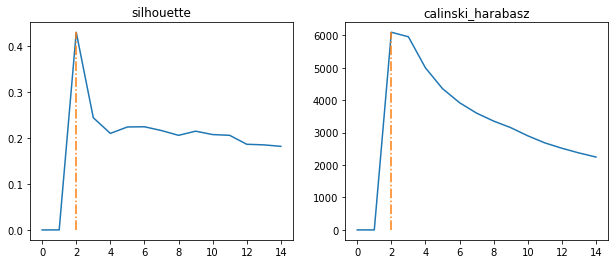

In [10]:
score_names = ['silhouette', 'calinski_harabasz']
plt.figure(figsize=(16, 4))
for s in range(2):
    plt.subplot(1,3,s + 1)
    plt.title(score_names[s])
    plt.plot(score[:, s])
    m = score[:, s].argmax()
    plt.plot([m, m], [0, score[m, s]], '-.')
plt.show()

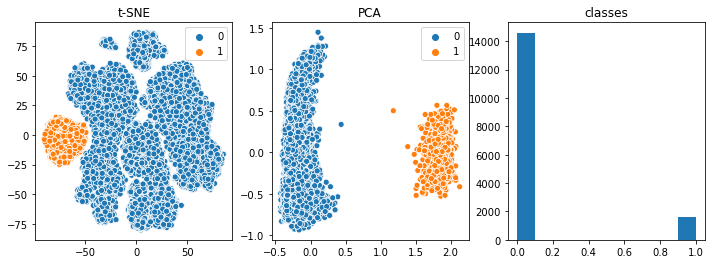

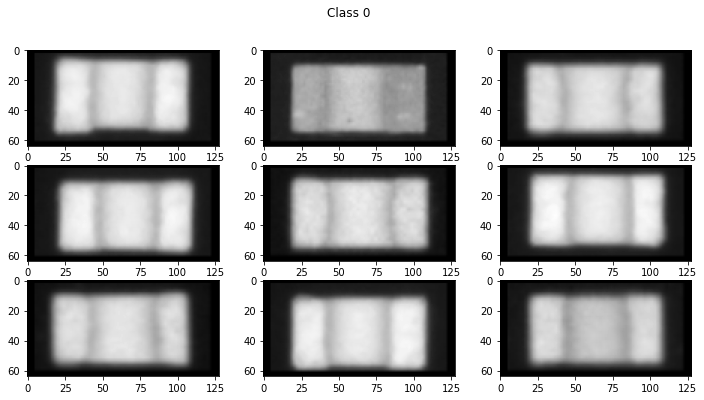

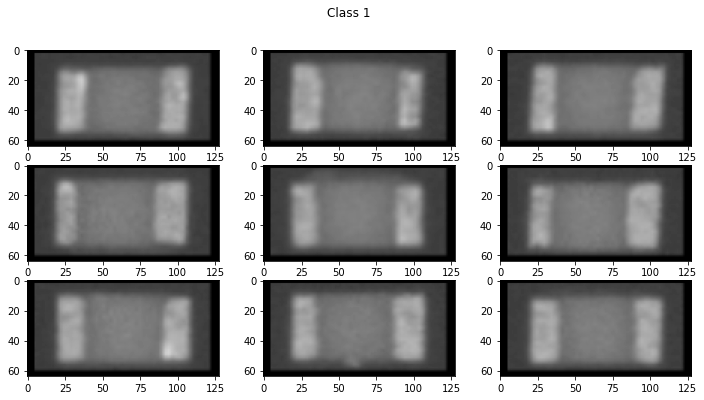

In [11]:
K = score[:, 0].argmax() 
labels = KMeans(n_clusters=K, max_iter=3000).fit_predict(points)
    
    
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.title('t-SNE')
sns.scatterplot(Xt[:, 0], Xt[:, 1], hue=labels)
plt.subplot(1,3,2)
plt.title('PCA')
sns.scatterplot(Xp[:, 0], Xp[:, 1], hue=labels)
plt.subplot(1,3,3)
plt.title('classes')
plt.hist(labels)
plt.show()      

for i in np.unique(labels):
    idx = np.where(labels == i)[0]
    jdx = np.random.choice(idx, 9)

    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Class {i}')
    for j in range(9):
        img = images[jdx[j], :, :]
        plt.subplot(3,3,j + 1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()


In [13]:
for i, name in enumerate(['A', 'B', 'C']):
    v = np.unique(labels[subset == i]).shape
    print(v)

(1,)
(1,)
(2,)
